<a href="https://colab.research.google.com/github/satvik-27199/Drug_Discovery/blob/main/Drug_discovery_optimize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/Drug discovery/Butyrylcholinesterase_01_bioactivity_data_raw.csv')
df.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,33968,[],CHEMBL654878,Inhibitory concentration against butyrylcholin...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004,"{'bei': '19.33', 'le': '0.36', 'lle': '3.24', ...",CHEMBL133897,NaN,CHEMBL133897,6.04,False,http://www.openphacts.org/units/Nanomolar,252547,=,1,True,=,NaN,IC50,nM,NaN,920.0,CHEMBL1914,Homo sapiens,Butyrylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.92
1,NaN,37562,[],CHEMBL654878,Inhibitory concentration against butyrylcholin...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004,"{'bei': '16.04', 'le': '0.33', 'lle': '1.50', ...",CHEMBL336398,NaN,CHEMBL336398,6.05,False,http://www.openphacts.org/units/Nanomolar,252533,=,1,True,=,NaN,IC50,nM,NaN,900.0,CHEMBL1914,Homo sapiens,Butyrylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.90
2,NaN,37566,[],CHEMBL654878,Inhibitory concentration against butyrylcholin...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004,NaN,CHEMBL131588,NaN,CHEMBL131588,NaN,False,http://www.openphacts.org/units/Nanomolar,252530,>,1,True,>,NaN,IC50,nM,NaN,50000.0,CHEMBL1914,Homo sapiens,Butyrylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,50.00
3,NaN,38901,[],CHEMBL654878,Inhibitory concentration against butyrylcholin...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004,"{'bei': '14.82', 'le': '0.32', 'lle': '1.29', ...",CHEMBL130628,NaN,CHEMBL130628,6.00,False,http://www.openphacts.org/units/Nanomolar,252534,=,1,True,=,NaN,IC50,nM,NaN,1000.0,CHEMBL1914,Homo sapiens,Butyrylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,1.00
4,NaN,41169,[],CHEMBL654878,Inhibitory concentration against butyrylcholin...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004,"{'bei': '19.34', 'le': '0.40', 'lle': '3.60', ...",CHEMBL130478,NaN,CHEMBL130478,6.70,False,http://www.openphacts.org/units/Nanomolar,252552,=,1,True,=,NaN,IC50,nM,NaN,200.0,CHEMBL1914,Homo sapiens,Butyrylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.20


In [75]:
pip install optunity

     |████████████████████████████████| 4.6 MB 7.4 MB/s 
  Created wheel for optunity: filename=Optunity-1.1.1-py3-none-any.whl size=72031 sha256=56a3310482d7680ac2a28d7268f433a6535e4ef37c5e8fd17a07cd6f6a0292d2
  Stored in directory: /root/.cache/pip/wheels/0d/0e/31/a4763ff822a20f88a61dd3bb1c8b78a8f25c605392fe956d07
Successfully built optunity


In [107]:
pip install tpot

     |████████████████████████████████| 87 kB 4.5 MB/s 
     |████████████████████████████████| 160 kB 63.7 MB/s 
     |████████████████████████████████| 166.7 MB 14 kB/s 
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11952 sha256=4d41df4dbb0a7822a5d85883187d37cf268619b3da9389d1b31a80b4961f9242
  Stored in directory: /root/.cache/pip/wheels/e2/d2/79/eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [42]:
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,33968,[],CHEMBL654878,Inhibitory concentration against butyrylcholin...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004,"{'bei': '19.33', 'le': '0.36', 'lle': '3.24', ...",CHEMBL133897,NaN,CHEMBL133897,6.04,False,http://www.openphacts.org/units/Nanomolar,252547,=,1,True,=,NaN,IC50,nM,NaN,920.0,CHEMBL1914,Homo sapiens,Butyrylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.92
1,NaN,37562,[],CHEMBL654878,Inhibitory concentration against butyrylcholin...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004,"{'bei': '16.04', 'le': '0.33', 'lle': '1.50', ...",CHEMBL336398,NaN,CHEMBL336398,6.05,False,http://www.openphacts.org/units/Nanomolar,252533,=,1,True,=,NaN,IC50,nM,NaN,900.0,CHEMBL1914,Homo sapiens,Butyrylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.90
2,NaN,37566,[],CHEMBL654878,Inhibitory concentration against butyrylcholin...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004,NaN,CHEMBL131588,NaN,CHEMBL131588,NaN,False,http://www.openphacts.org/units/Nanomolar,252530,>,1,True,>,NaN,IC50,nM,NaN,50000.0,CHEMBL1914,Homo sapiens,Butyrylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,50.00
3,NaN,38901,[],CHEMBL654878,Inhibitory concentration against butyrylcholin...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004,"{'bei': '14.82', 'le': '0.32', 'lle': '1.29', ...",CHEMBL130628,NaN,CHEMBL130628,6.00,False,http://www.openphacts.org/units/Nanomolar,252534,=,1,True,=,NaN,IC50,nM,NaN,1000.0,CHEMBL1914,Homo sapiens,Butyrylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,1.00
4,NaN,41169,[],CHEMBL654878,Inhibitory concentration against butyrylcholin...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004,"{'bei': '19.34', 'le': '0.40', 'lle': '3.60', ...",CHEMBL130478,NaN,CHEMBL130478,6.70,False,http://www.openphacts.org/units/Nanomolar,252552,=,1,True,=,NaN,IC50,nM,NaN,200.0,CHEMBL1914,Homo sapiens,Butyrylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.20


In [43]:
len(df2.canonical_smiles.unique())

2912

In [44]:
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,33968,[],CHEMBL654878,Inhibitory concentration against butyrylcholin...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004,"{'bei': '19.33', 'le': '0.36', 'lle': '3.24', ...",CHEMBL133897,NaN,CHEMBL133897,6.04,False,http://www.openphacts.org/units/Nanomolar,252547,=,1,True,=,NaN,IC50,nM,NaN,920.0,CHEMBL1914,Homo sapiens,Butyrylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.92
1,NaN,37562,[],CHEMBL654878,Inhibitory concentration against butyrylcholin...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004,"{'bei': '16.04', 'le': '0.33', 'lle': '1.50', ...",CHEMBL336398,NaN,CHEMBL336398,6.05,False,http://www.openphacts.org/units/Nanomolar,252533,=,1,True,=,NaN,IC50,nM,NaN,900.0,CHEMBL1914,Homo sapiens,Butyrylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.90
2,NaN,37566,[],CHEMBL654878,Inhibitory concentration against butyrylcholin...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004,NaN,CHEMBL131588,NaN,CHEMBL131588,NaN,False,http://www.openphacts.org/units/Nanomolar,252530,>,1,True,>,NaN,IC50,nM,NaN,50000.0,CHEMBL1914,Homo sapiens,Butyrylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,50.00
3,NaN,38901,[],CHEMBL654878,Inhibitory concentration against butyrylcholin...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004,"{'bei': '14.82', 'le': '0.32', 'lle': '1.29', ...",CHEMBL130628,NaN,CHEMBL130628,6.00,False,http://www.openphacts.org/units/Nanomolar,252534,=,1,True,=,NaN,IC50,nM,NaN,1000.0,CHEMBL1914,Homo sapiens,Butyrylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,1.00
4,NaN,41169,[],CHEMBL654878,Inhibitory concentration against butyrylcholin...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004,"{'bei': '19.34', 'le': '0.40', 'lle': '3.60', ...",CHEMBL130478,NaN,CHEMBL130478,6.70,False,http://www.openphacts.org/units/Nanomolar,252552,=,1,True,=,NaN,IC50,nM,NaN,200.0,CHEMBL1914,Homo sapiens,Butyrylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.20


In [45]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
df3.head()

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,920.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,900.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,1000.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,200.0


In [46]:
df4 = pd.read_csv('/content/drive/MyDrive/Drug discovery/Butyrylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [47]:
bioactivity_threshold = []
# 0 active, 1 intermediate, 2 inactive
for i in df4.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append(2)
  elif float(i) <= 1000:
    bioactivity_threshold.append(0)
  else:
    bioactivity_threshold.append(1)

In [48]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df5 = pd.concat([df4, bioactivity_class], axis=1)
df5.head()

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,920.0,0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,900.0,0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,2
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,1000.0,0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,200.0,0


In [49]:
df5['class'].value_counts()

2    1114
0    1050
1     748
Name: class, dtype: int64

In [50]:
df = pd.read_csv('/content/drive/MyDrive/Drug discovery/Butrylcholinesterase_03_bioactivity_data_curated.csv')
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,920.0,0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,900.0,0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,2
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,1000.0,0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,200.0,0


In [51]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [52]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [53]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles.head()

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL133897,920.0,0,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1,CHEMBL336398,900.0,0,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2,CHEMBL131588,50000.0,2,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1
3,CHEMBL130628,1000.0,0,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F
4,CHEMBL130478,200.0,0,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C


In [55]:
df_clean_smiles.shape

(2912, 4)

In [54]:
df_final = pd.read_csv("/content/drive/MyDrive/Drug discovery/Butyrylcholinesterase_04_bioactivity_data_3class_pIC50.csv")

In [18]:
df_2class = df_final[df_final['class'] != 1]
df_2class

,Unnamed: 0,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,0,312.325,2.80320,0.0,6.0,6.036212
1,1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,0,376.913,4.55460,0.0,5.0,6.045757
2,2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,2,426.851,5.35740,0.0,5.0,4.301030
3,3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,0,404.845,4.70690,0.0,5.0,6.000000
4,4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,0,346.334,3.09530,0.0,6.0,6.698970
...,...,...,...,...,...,...,...,...,...
2906,2906,CHEMBL4649430,COc1c2c(cc3c1OCO3)[C@]13C=C[C@H](OC)C[C@@H]1N(...,2,331.368,1.19530,1.0,6.0,4.000000
2907,2907,CHEMBL4638758,Cc1ccc2cc(NC(=O)Cn3c(-c4nonc4N)nc4ccccc43)ccc2n1,0,399.414,3.16382,2.0,8.0,6.494850
2909,2909,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1.Cl,2,306.406,2.70270,2.0,4.0,4.974694
2910,2910,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,0,447.506,5.11430,1.0,5.0,7.008774


In [19]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

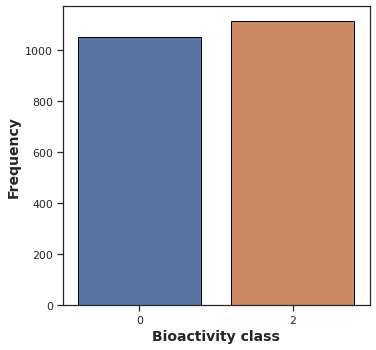

In [21]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')
#sns.countplot(x='class', data=df_final, edgecolor='black')
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:1026: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


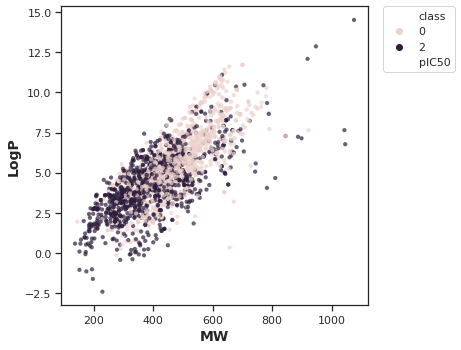

In [23]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)
#sns.scatterplot(x='MW', y='LogP', data=df_final, hue='class', size='pIC50', edgecolor='black', alpha=0.7)
plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
#plt.savefig('plot_MW_vs_LogP.pdf')

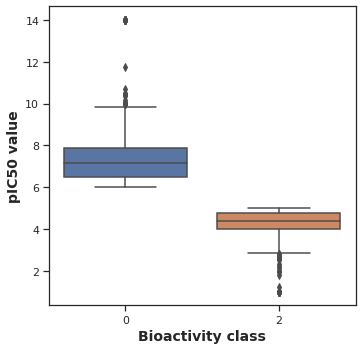

In [24]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)
#sns.boxplot(x = 'class', y = 'pIC50', data = df_final)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [25]:
def mannwhitney(descriptor, verbose=False):
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  #df = df_final[selection]
  active = df[df['class'] == 0]
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  #df = df_final[selection]
  inactive = df[df['class'] == 1]
  inactive = inactive[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  #df = df_final[selection]
  inactive = df[df['class'] == 2]
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [27]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,0.0,0.05,Different distribution (reject H0)


In [28]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,389064.5,1.063279e-41,0.05,Different distribution (reject H0)


In [29]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,397142.5,1.707436e-38,0.05,Different distribution (reject H0)


In [31]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,401068.5,1.155385e-39,0.05,Different distribution (reject H0)


In [32]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,537222.0,0.000434,0.05,Different distribution (reject H0)


In [33]:
import pandas as pd
df3_X = pd.read_csv('/content/drive/MyDrive/Drug discovery/descriptors_output_Butyrylcholinesterase.csv')

In [34]:
df3_X.head()

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL336398,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CHEMBL133897,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CHEMBL130628,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CHEMBL131588,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CHEMBL130478,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
df3_X.shape

(2912, 882)

In [37]:
df3_X = df3_X.drop(columns=['Name'])
df3_X.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,920.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,900.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,1000.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,200.0
...,...,...,...
3642,CHEMBL4638758,Cc1ccc2cc(NC(=O)Cn3c(-c4nonc4N)nc4ccccc43)ccc2n1,320.0
3643,CHEMBL4635686,CN(C)C(=O)Oc1cccc(C(O)CNC2CCCCC2)c1.Cl,2200.0
3644,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1.Cl,10600.0
3645,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,98.0


In [56]:
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,920.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,900.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,1000.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,200.0
...,...,...,...
3642,CHEMBL4638758,Cc1ccc2cc(NC(=O)Cn3c(-c4nonc4N)nc4ccccc43)ccc2n1,320.0
3643,CHEMBL4635686,CN(C)C(=O)Oc1cccc(C(O)CNC2CCCCC2)c1.Cl,2200.0
3644,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1.Cl,10600.0
3645,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,98.0


In [57]:
df5

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,920.0,0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,900.0,0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,2
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,1000.0,0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,200.0,0
...,...,...,...,...
2907,CHEMBL4638758,Cc1ccc2cc(NC(=O)Cn3c(-c4nonc4N)nc4ccccc43)ccc2n1,320.0,0
2908,CHEMBL4635686,CN(C)C(=O)Oc1cccc(C(O)CNC2CCCCC2)c1.Cl,2200.0,1
2909,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1.Cl,10600.0,2
2910,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,98.0,0


In [58]:
df3_Y = df5['class']
df3_Y.value_counts()

2    1114
0    1050
1     748
Name: class, dtype: int64

In [60]:
dataset3 = pd.concat([df3_X,df3_Y], axis=1)
dataset3.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,class
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
dataset3.shape

(2912, 882)

In [63]:
dataset3 = dataset3[dataset3['class'] != 1]
dataset3.shape

(2164, 882)

In [64]:
X = dataset3.drop('class', axis=1)
Y = dataset3['class']

In [65]:
import numpy as np
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.70)]
X = X.drop(to_drop, axis=1)

In [66]:
X.shape

(2164, 521)

In [67]:
from sklearn.decomposition import PCA
pca=PCA(n_components=30)
pca.fit(X)
x_pca=pca.transform(X)

In [68]:
x_pca.shape

(2164, 30)

In [69]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(x_pca, Y, test_size=0.2, random_state = 42)

In [71]:
len(Y_train)

1731

In [110]:
start = time.time()
model = RandomForestClassifier(random_state=42)
model.fit(X_train, Y_train)
end = time.time()
print(end-start)
scores = cross_val_score(model, X_train, Y_train, cv = 3, scoring='accuracy')
print("Accuracy:"+ str(scores.mean()))

0.6079280376434326
Accuracy:0.8405545927209706


In [99]:
Y_pred = model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85       233
           2       0.80      0.88      0.84       200

    accuracy                           0.85       433
   macro avg       0.85      0.85      0.85       433
weighted avg       0.85      0.85      0.85       433



In [100]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.svm import SVC,SVR

In [105]:
#Random Forest
import time
start = time.time()
import optunity
import optunity.metrics

data=X_train
labels=Y_train.tolist()
# Define the hyperparameter configuration space
search = {
    'n_estimators': [10, 100],
    'max_features': [1, 64],
    'max_depth': [5,50],
    "min_samples_split":[2,5],
    "min_samples_leaf":[1,5],
    "criterion":[0,1]
         }
# Define the objective function
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_estimators=None, max_features=None,max_depth=None,min_samples_split=None,min_samples_leaf=None,criterion=None):
    # fit the model
    if criterion<0.5:
        cri='gini'
    else:
        cri='entropy'
    model = RandomForestClassifier(n_estimators=int(n_estimators),
                                   max_features=int(max_features),
                                   max_depth=int(max_depth), random_state = 42,
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf),
                                   criterion=cri,
                                  )
    #predictions = model.predict(x_test)
    scores=np.mean(cross_val_score(model, X_train, Y_train, cv=3, n_jobs=-1,
                                    scoring="accuracy"))
    #return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return scores#optunity.metrics.accuracy(y_test, predictions)

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )
end = time.time()
print(end-start)
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))
#accuacy 84.45

22.935155630111694
{'n_estimators': 81.5869140625, 'max_features': 47.54248046875, 'max_depth': 47.07763671875, 'min_samples_split': 2.09814453125, 'min_samples_leaf': 3.857421875, 'criterion': 0.67041015625}
Accuracy:nan


In [109]:
#Random Forest
import time
start = time.time()
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
        'n_estimators': range(10,100),
    "max_features":range(1,64),
    'max_depth': range(10,100),
    "min_samples_split":range(2,5),
    "min_samples_leaf":range(1,5),
    "criterion":['gini','entropy']
             }
# Set the hyperparameters of GA                 
ga2 = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.ensemble.RandomForestClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
ga2.fit(X_train, Y_train)
end = time.time()
print(end-start)

1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 max_features must be in (0, n_features].
_pre_test decorator: _random_mutation_operator: num_test=1 max_features must be in (0, n_features].

Generation 1 - Current Pareto front scores:

-1	0.8486424032351242	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=38, RandomForestClassifier__max_features=11, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=80)
_pre_test decorator: _random_mutation_operator: num_test=0 max_features must be in (0, n_features].
_pre_test decorator: _random_mutation_operator: num_test=1 max_features must be in (0, n_features].
_pre_test decorator: _random_mutation_operator: num_test=2 max_features must be in (0, n_features].
_pre_test decorator: _random_mutation_operator: num_test=3 max_features must be in (0, n_features].
_pre_test decorat

In [120]:
#SVM
start = time.time()
clf = SVC(gamma='scale', random_state = 42)
clf.fit(X_train, Y_train)
end = time.time()
print(end-start)
scores = cross_val_score(clf, X_train, Y_train, cv=3,scoring='accuracy')
print("Accuracy:"+ str(scores.mean()))

0.125105619430542
Accuracy:0.8428653957250144


In [121]:
X = X_train.copy()
y = Y_train.copy()
#SVM
start = time.time()
import optunity
import optunity.metrics

data=X
labels=y.tolist()

search = {
    'C': (0,50),
    'kernel':[0,4]
         }
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,C=None,kernel=None):
    # fit the model
    if kernel<1:
        ke='linear'
    elif kernel<2:
        ke='poly'
    elif kernel<3:
        ke='rbf'
    else:
        ke='sigmoid'
    model = SVC(C=float(C),random_state=42,
                kernel=ke
                                  )
    #predictions = model.predict(x_test)
    scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    scoring="accuracy"))
    #return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return scores#optunity.metrics.accuracy(y_test, predictions)

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )
end = time.time()
print(end-start)
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

17.894021034240723
{'C': 2.8076171875, 'kernel': 2.224609375}
Accuracy:0.8445984979780473


In [124]:
start = time.time()
#SVM
from tpot import TPOTClassifier

parameters = {
    'C': np.random.uniform(0,50,3000),
    "kernel":['linear','poly','rbf','sigmoid']
             }
               
ga2 = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.svm.SVC': parameters}, 
                                 cv = 3, scoring = 'accuracy')
ga2.fit(X, y)
end = time.time()
print(end-start)

1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.8393991912189486	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=18.28684025166102, SVC__kernel=rbf)

-2	0.852686308492201	SVC(SVC(input_matrix, SVC__C=1.9583513846066547, SVC__kernel=rbf), SVC__C=36.0650695321992, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.8393991912189486	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=18.28684025166102, SVC__kernel=rbf)

-2	0.852686308492201	SVC(SVC(input_matrix, SVC__C=1.9583513846066547, SVC__kernel=rbf), SVC__C=36.0650695321992, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.8393991912189486	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=18.28684025166102, SVC__kernel=rbf)

-2	0.852686308492201	SVC(SVC(input_matrix, SVC__C=1.9583513846066547, SVC__kernel=rbf), SVC__C=36.0650695321992, SVC__kernel=rbf)
17.072227478027344


In [125]:
#KNN
start = time.time()
from tpot import TPOTClassifier

parameters = {
    'n_neighbors': range(1,20),
             }
               
ga2 = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.neighbors.KNeighborsClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
ga2.fit(X, y)
end = time.time()
print(end-start)

1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.8266897746967071	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5)

-2	0.831889081455806	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=4), KNeighborsClassifier__n_neighbors=18)

Generation 2 - Current Pareto front scores:

-1	0.8341998844598498	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)

Generation 3 - Current Pareto front scores:

-1	0.8341998844598498	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1)
10.905232429504395


In [133]:
start = time.time()
import optunity
import optunity.metrics

data=X
labels=y.tolist()

search = {
    'n_neighbors': [1, 20],
         }
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_neighbors=None):
    # fit the model
    model = KNeighborsClassifier(n_neighbors=int(n_neighbors),
                                  )
    scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    scoring="accuracy"))
    return scores

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=10,
                                                   **search
                                                  )
end = time.time()
print(end-start)
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

4.081212997436523
{'n_neighbors': 3.7275390625}
Accuracy:0.8376660889659157


In [128]:
start = time.time()
clf = KNeighborsClassifier()
clf.fit(X,y)
end = time.time()
print(end-start)
scores = cross_val_score(clf, X, y, cv=3,scoring='accuracy')
print("Accuracy:"+ str(scores.mean()))

0.007938861846923828
Accuracy:0.8266897746967071


Regression

In [156]:
dataset3.shape

(2164, 882)

In [158]:
Y = df_2class['pIC50']
Y = pd.DataFrame(Y)
df = pd.concat([dataset3, Y], axis=1)
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
M = clean_dataset(df)

In [159]:
M.shape

(2163, 883)

In [160]:
M.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,class,pIC50
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.036212
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.045757
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.301030
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.000000
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.698970


In [161]:
features = M.iloc[:,:-2]
valuess = M.iloc[:,-1]

In [165]:
import numpy as np
cor_matrix = features.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.70)]
X = features.drop(to_drop, axis=1)

In [166]:
X.shape

(2163, 521)

In [167]:
from sklearn.decomposition import PCA
pca=PCA(n_components=30)
pca.fit(X)
x_pca=pca.transform(X)

In [168]:
X_train, X_test, Y_train, Y_test = train_test_split(x_pca, valuess, test_size=0.2, random_state = 42)

In [169]:
X_train.shape

(1730, 30)

In [170]:
Y_train

1487    6.455932
527     4.679854
2083    4.040005
1712    8.263603
1066    6.096910
          ...   
2134    6.657577
1435    5.000000
1484    6.022276
1677    4.397940
1132    7.368556
Name: pIC50, Length: 1730, dtype: float64

In [171]:
X = X_train.copy()
y = Y_train.copy()

In [172]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.svm import SVC,SVR
from sklearn import datasets
import scipy.stats as stats

In [175]:
model = RandomForestRegressor(n_estimators=1000)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.4989760888342762

In [191]:
#Random Forest
import time
start = time.time()
clf = RandomForestRegressor()
scores1 = cross_val_score(clf, X, y, cv=3, scoring='neg_mean_absolute_error')
end = time.time()
scores2 = cross_val_score(clf, X, y, cv=3,scoring='neg_root_mean_squared_error')
print(end-start)
print("MAE:"+ str(-scores1.mean()))
print("RMSE:"+ str(-scores2.mean()))

5.927391290664673
MAE:0.869527866379377
RMSE:1.2865771188330857


In [192]:
#SVM
import time
start = time.time()
clf = SVR(gamma='scale')
scores1 = cross_val_score(clf, X, y, cv=3,scoring='neg_mean_absolute_error')
end = time.time()
scores2 = cross_val_score(clf, X, y, cv=3,scoring='neg_root_mean_squared_error')
print(end-start)
print("MAE:"+ str(-scores1.mean()))
print("RMSE:"+ str(-scores2.mean()))

0.4940609931945801
MAE:0.8221876666943696
RMSE:1.3803301626310318


In [206]:

#KNN
import time
start = time.time()
clf = KNeighborsRegressor()
scores1 = cross_val_score(clf, X, y, cv=3,scoring='neg_mean_absolute_error')
end = time.time()
scores2 = cross_val_score(clf, X, y, cv=3,scoring='neg_root_mean_squared_error')
print(end-start)
print("MAE:"+ str(-scores1.mean()))
print("RMSE:"+ str(-scores2.mean()))

0.08735203742980957
MAE:0.8132946599407694
RMSE:1.2607110667987564


In [196]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.5013384765901576

In [204]:
Y_pred = model.predict(X_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show>

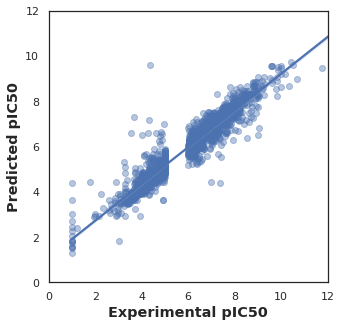

In [205]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_train, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

In [224]:

#Random Forest
import optunity
import optunity.metrics
start = time.time()
# Define the hyperparameter configuration space
search = {
    'n_estimators': [10, 100],
    'max_features': [1, 13],
    'max_depth': [5,50],
    "min_samples_split":[2,11],
    "min_samples_leaf":[1,11],
         }
# Define the objective function
@optunity.cross_validated(x=X, y=y.tolist(), num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_estimators=None, max_features=None,max_depth=None,min_samples_split=None,min_samples_leaf=None):
    # fit the model
    model = RandomForestRegressor(n_estimators=int(n_estimators),
                                   max_features=int(max_features),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf),
                                  )
    scores=-np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    scoring="neg_root_mean_squared_error"))
    return scores

optimal_configuration, info, _ = optunity.minimize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )
end = time.time()
print(end-start)
print(optimal_configuration)
print("MSE:"+ str(info.optimum))

24.528793334960938
{'n_estimators': 46.365840514774845, 'max_features': 10.889453125, 'max_depth': 40.37158203125, 'min_samples_split': 3.16103515625, 'min_samples_leaf': 4.0478515625}
MSE:1.284372557826325


In [225]:

#Random Forest
import optunity
import optunity.metrics
start = time.time()
# Define the hyperparameter configuration space
search = {
    'n_estimators': [10, 100],
    'max_features': [1, 13],
    'max_depth': [5,50],
    "min_samples_split":[2,11],
    "min_samples_leaf":[1,11],
         }
# Define the objective function
@optunity.cross_validated(x=X, y=y.tolist(), num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_estimators=None, max_features=None,max_depth=None,min_samples_split=None,min_samples_leaf=None):
    # fit the model
    model = RandomForestRegressor(n_estimators=int(n_estimators),
                                   max_features=int(max_features),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf),
                                  )
    scores=-np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))
    return scores

optimal_configuration, info, _ = optunity.minimize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )
end = time.time()
print(end-start)
print(optimal_configuration)
print("MSE:"+ str(info.optimum))

30.878340244293213
{'n_estimators': 55.3955078125, 'max_features': 11.482421875, 'max_depth': 34.86083984375, 'min_samples_split': 4.59716796875, 'min_samples_leaf': 2.7333984375}
MSE:0.8723410314354081


In [217]:

#SVM
import optunity
import optunity.metrics
import time
start = time.time()
search = {
    'C': (0,50),
    'kernel':[0,3],
    'epsilon': (0, 1)
         }
@optunity.cross_validated(x=X, y=y.tolist(), num_folds=3)
def performance(x_train, y_train, x_test, y_test,C=None,kernel=None,epsilon=None):
    # fit the model
    if kernel<1:
        ke='poly'
    elif kernel<2:
        ke='rbf'
    else:
        ke='sigmoid'
    model = SVR(C=float(C),
                kernel=ke,
                gamma='scale',
                epsilon=float(epsilon)
                                  )

    scores=-np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    scoring="neg_root_mean_squared_error"))

    return scores

optimal_configuration, info, _ = optunity.minimize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )
end = time.time()
print(end-start)
print(optimal_configuration)
print("MSE:"+ str(info.optimum))

22.061824798583984
{'C': 13.968700567025909, 'kernel': 1.6057617187500002, 'epsilon': 0.36577371537075165}
MSE:1.2151739904043328


In [218]:
#SVM
import optunity
import optunity.metrics
import time
start = time.time()
search = {
    'C': (0,50),
    'kernel':[0,3],
    'epsilon': (0, 1)
         }
@optunity.cross_validated(x=X, y=y.tolist(), num_folds=3)
def performance(x_train, y_train, x_test, y_test,C=None,kernel=None,epsilon=None):
    # fit the model
    if kernel<1:
        ke='poly'
    elif kernel<2:
        ke='rbf'
    else:
        ke='sigmoid'
    model = SVR(C=float(C),
                kernel=ke,
                gamma='scale',
                epsilon=float(epsilon)
                                  )

    scores=-np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

    return scores

optimal_configuration, info, _ = optunity.minimize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )
end = time.time()
print(end-start)
print(optimal_configuration)
print("MSE:"+ str(info.optimum))

24.869441509246826
{'C': 20.244140625, 'kernel': 1.4632549809045619, 'epsilon': 0.08530538489925613}
MSE:0.7830566432694512


In [220]:
#KNN
import optunity
import optunity.metrics
start = time.time()
search = {
    'n_neighbors': [1, 20],
         }
@optunity.cross_validated(x=X, y=y.tolist(), num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_neighbors=None):
    # fit the model
    model = KNeighborsRegressor(n_neighbors=int(n_neighbors),
                                  )

    scores=-np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    scoring="neg_root_mean_squared_error"))

    return scores

optimal_configuration, info, _ = optunity.minimize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=10,
                                                   **search
                                                  )
end = time.time()
print(end-start)
print(optimal_configuration)
print("MSE:"+ str(info.optimum))

3.0071191787719727
{'n_neighbors': 4.01513671875}
MSE:1.2556664701576794


In [221]:
#KNN
import optunity
import optunity.metrics
start = time.time()
search = {
    'n_neighbors': [1, 20],
         }
@optunity.cross_validated(x=X, y=y.tolist(), num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_neighbors=None):
    # fit the model
    model = KNeighborsRegressor(n_neighbors=int(n_neighbors),
                                  )

    scores=-np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

    return scores

optimal_configuration, info, _ = optunity.minimize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=10,
                                                   **search
                                                  )
end = time.time()
print(end-start)
print(optimal_configuration)
print("MSE:"+ str(info.optimum))

2.8742406368255615
{'n_neighbors': 2.9853515625}
MSE:0.763213830206546


In [232]:

#KNN
from tpot import TPOTRegressor
start = time.time()
parameters = {
    'n_neighbors': range(1,20),
             }
               
ga2 = TPOTRegressor(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.neighbors.KNeighborsRegressor': parameters}, 
                                 cv = 3, scoring = 'neg_root_mean_squared_error')
ga2.fit(X, y)
end = time.time()
print(start-end)

1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	-1.2420474724717943	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=3)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	-1.2420474724717943	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=3)

Generation 3 - Current Pareto front scores:

-1	-1.2420474724717943	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=3)
-5.554286956787109


In [231]:

#KNN
from tpot import TPOTRegressor
start = time.time()
parameters = {
    'n_neighbors': range(1,20),
             }
               
ga2 = TPOTRegressor(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.neighbors.KNeighborsRegressor': parameters}, 
                                 cv = 3, scoring = 'neg_mean_absolute_error')
ga2.fit(X, y)
end = time.time()
print(start-end)

-0.000102996826171875
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	-0.763213830206546	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=2)

Generation 2 - Current Pareto front scores:

-1	-0.763213830206546	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=2)

-2	-0.7499612264108331	KNeighborsRegressor(KNeighborsRegressor(CombineDFs(input_matrix, input_matrix), KNeighborsRegressor__n_neighbors=1), KNeighborsRegressor__n_neighbors=12)

Generation 3 - Current Pareto front scores:

-1	-0.763213830206546	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=2)

-2	-0.7378815596712073	KNeighborsRegressor(KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=1), KNeighborsRegressor__n_neighbors=12)


TPOTRegressor(config_dict={'sklearn.neighbors.KNeighborsRegressor': {'n_neighbors': range(1, 20)}},
              crossover_rate=0.1, cv=3, disable_update_check=False,
              early_stop=5, generations=3, log_file=None, max_eval_time_mins=5,
              max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
              offspring_size=5, periodic_checkpoint_folder=None,
              population_size=10, random_state=None,
              scoring='neg_mean_absolute_error', subsample=1.0, template=None,
              use_dask=False, verbosity=3, warm_start=False)

In [233]:

#SVM
from tpot import TPOTRegressor
start = time.time()
parameters = {
    'C': np.random.uniform(0,50,1000),
    "kernel":['poly','rbf','sigmoid'],
    'epsilon': np.random.uniform(0,1,100),
    'gamma': ['scale']
             }
               
ga2 = TPOTRegressor(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.svm.SVR': parameters}, 
                                 cv = 3, scoring = 'neg_root_mean_squared_error')
ga2.fit(X, y)
end = time.time()
print(start-end)

1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	-1.2331634913749927	SVR(CombineDFs(input_matrix, input_matrix), SVR__C=27.78266434151137, SVR__epsilon=0.4751598910631625, SVR__gamma=scale, SVR__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	-1.2331634913749927	SVR(CombineDFs(input_matrix, input_matrix), SVR__C=27.78266434151137, SVR__epsilon=0.4751598910631625, SVR__gamma=scale, SVR__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	-1.2331634913749927	SVR(CombineDFs(input_matrix, input_matrix), SVR__C=27.78266434151137, SVR__epsilon=0.4751598910631625, SVR__gamma=scale, SVR__kernel=rbf)
-23.24371337890625


In [234]:

#SVM
from tpot import TPOTRegressor
start = time.time()
parameters = {
    'C': np.random.uniform(0,50,1000),
    "kernel":['poly','rbf','sigmoid'],
    'epsilon': np.random.uniform(0,1,100),
    'gamma': ['scale']
             }
               
ga2 = TPOTRegressor(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.svm.SVR': parameters}, 
                                 cv = 3, scoring = 'neg_mean_absolute_error')
ga2.fit(X, y)
end = time.time()
print(start-end)

1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	-0.7996959231504639	SVR(input_matrix, SVR__C=5.904294630529589, SVR__epsilon=0.10997774936076543, SVR__gamma=scale, SVR__kernel=poly)

-2	-0.7711889521514266	SVR(SVR(input_matrix, SVR__C=4.587002069736224, SVR__epsilon=0.6951475765892688, SVR__gamma=scale, SVR__kernel=rbf), SVR__C=5.904294630529589, SVR__epsilon=0.10997774936076543, SVR__gamma=scale, SVR__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	-0.7996959231504639	SVR(input_matrix, SVR__C=5.904294630529589, SVR__epsilon=0.10997774936076543, SVR__gamma=scale, SVR__kernel=poly)

-2	-0.7711889521514266	SVR(SVR(input_matrix, SVR__C=4.587002069736224, SVR__epsilon=0.6951475765892688, SVR__gamma=scale, SVR__kernel=rbf), SVR__C=5.904294630529589, SVR__epsilon=0.10997774936076543, SVR__gamma=scale, SVR__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	-0.7948288445911085	SVR(input_matrix, SVR__C=17.835177147661206, SVR__epsilon=0.38037141544363406, SVR__gamma=s

In [239]:

#Random Forest
from tpot import TPOTRegressor
# Define the hyperparameter configuration space
start = time.time()
parameters = {
    'n_estimators': range(10,100),
    "max_features":range(1,13),
    'max_depth': range(10,100),
    "min_samples_split":range(2,11),
    "min_samples_leaf":range(1,11),
    #"criterion":['mse','mae']
             }
# Set the hyperparameters of GA               
ga2 = TPOTRegressor(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.ensemble.RandomForestRegressor': parameters}, 
                                 cv = 3, scoring = 'neg_root_mean_squared_error')
ga2.fit(X, y)
end = time.time()
print(start- end)

1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	-1.279792260510215	RandomForestRegressor(input_matrix, RandomForestRegressor__max_depth=54, RandomForestRegressor__max_features=5, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=2, RandomForestRegressor__n_estimators=94)

-2	-1.2499913914509622	RandomForestRegressor(RandomForestRegressor(input_matrix, RandomForestRegressor__max_depth=14, RandomForestRegressor__max_features=8, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=4, RandomForestRegressor__n_estimators=60), RandomForestRegressor__max_depth=14, RandomForestRegressor__max_features=12, RandomForestRegressor__min_samples_leaf=10, RandomForestRegressor__min_samples_split=4, RandomForestRegressor__n_estimators=57)

Generation 2 - Current Pareto front scores:

-1	-1.279792260510215	RandomForestRegressor(input_matrix, RandomForestRegressor__max_depth=54, RandomForestRegressor__max_features=5, RandomForestRegressor_

In [238]:

#Random Forest
from tpot import TPOTRegressor
# Define the hyperparameter configuration space
start = time.time()
parameters = {
    'n_estimators': range(10,100),
    "max_features":range(1,13),
    'max_depth': range(10,100),
    "min_samples_split":range(2,11),
    "min_samples_leaf":range(1,11),
    #"criterion":['mse','mae']
             }
# Set the hyperparameters of GA               
ga2 = TPOTRegressor(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.ensemble.RandomForestRegressor': parameters}, 
                                 cv = 3, scoring = 'neg_mean_absolute_error')
ga2.fit(X, y)
end = time.time()
print(start- end)

1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	-0.9115955517787503	RandomForestRegressor(input_matrix, RandomForestRegressor__max_depth=42, RandomForestRegressor__max_features=8, RandomForestRegressor__min_samples_leaf=4, RandomForestRegressor__min_samples_split=4, RandomForestRegressor__n_estimators=31)

-2	-0.814710474518487	RandomForestRegressor(RandomForestRegressor(input_matrix, RandomForestRegressor__max_depth=99, RandomForestRegressor__max_features=4, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=5, RandomForestRegressor__n_estimators=83), RandomForestRegressor__max_depth=58, RandomForestRegressor__max_features=9, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=92)

Generation 2 - Current Pareto front scores:

-1	-0.9115955517787503	RandomForestRegressor(input_matrix, RandomForestRegressor__max_depth=42, RandomForestRegressor__max_features=8, RandomForestRegressor__